# Bhargav J Shetgaonkar
Train an agent to play CartPole-v1* using A2C with N workers/1 worker (5 points)

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (608 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 174 kB 7.0 MB/s 


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3.common.env_util import make_vec_env

In [ ]:
env_id = 'CartPole-v1'
# The different number of processes that will be used
WORKERS_TO_TEST = [1, 2, 4, 8, 16] 
NUM_EXPERIMENTS = 3 # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
# Number of episodes for evaluation
EVAL_EPS = 20
ALGO = A2C

# We will create one environment to evaluate the agent on
eval_env = gym.make(env_id)

In [ ]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in WORKERS_TO_TEST:
    total_procs += n_procs
    print('Running for workers = {}'.format(n_procs))
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        # Here we use the "fork" method for launching the processes, more information is available in the doc
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        train_env = make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _  = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    # Important: when using subprocess, don't forget to close them
    # otherwise, you may have memory issues when running a lot of experiments
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))
    print('=============================================')
    print('avg rewards:', np.mean(rewards))
    print('std rewards:', np.std(rewards))
    print('mean training times:', np.mean(times))

Running for workers = 1


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


avg rewards: 386.34999999999997
std rewards: 160.4779476023627
mean training times: 7.306289990743001
Running for workers = 2
avg rewards: 69.56666666666668
std rewards: 19.654614951427792
mean training times: 5.479369084040324
Running for workers = 4
avg rewards: 261.0833333333333
std rewards: 90.84677882138817
mean training times: 3.4281839529673257
Running for workers = 8
avg rewards: 116.3
std rewards: 39.95555864540836
mean training times: 2.2992857297261557
Running for workers = 16
avg rewards: 53.68333333333334
std rewards: 41.90818005539677
mean training times: 1.6621910730997722


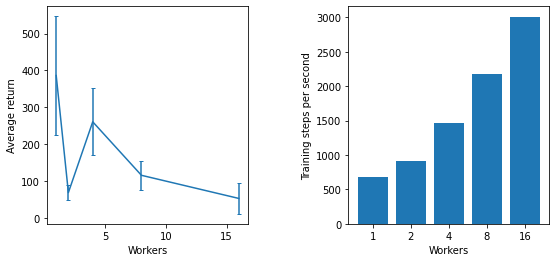

In [ ]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plt.figure(figsize=(9, 4))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
plt.errorbar(WORKERS_TO_TEST, reward_averages, yerr=reward_std, capsize=2)
plt.xlabel('Workers')
plt.ylabel('Average return')
plt.subplot(1, 2, 2)
plt.bar(range(len(WORKERS_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(WORKERS_TO_TEST)), WORKERS_TO_TEST)
plt.xlabel('Workers')
_ = plt.ylabel('Training steps per second')